# Analysing Audio Similarity with Spark Machine Learning

In this notebook, we will use a collection of datasets referred to as the Million Song Dataset (MSD),
a project initiated by The Echo Nest and LabROSA. The Echo Nest was a research spin-off from the
MIT Media Lab established with the goal of understanding the audio and textual content of recorded
music, and was acquired by Spotify after 10 years for 50 million Euro. 

Besides, the Music Information Retrieval research group at the Vienna University of Technology downloaded
audio samples for 994,960 songs in the dataset which were available from an online content provider,
most in the form of 30 or 60 second snippets. They used these snippets to extract a multitude of features
to allow comparison between the songs and prediction of song attributes. 

We will use the Spark.ml library, to build  various classification models that explore using numerical representations of a song’s audio waveform to predict its genre.

In [1]:
# Function to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))


In [ ]:
# Start Spark
start_spark(executor_instances=4, executor_cores=4, worker_memory=4, master_memory=4)

In [3]:
# Import 
from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.sql.functions import regexp_replace, sum, col, row_number, rand, udf
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RankingEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.recommendation import ALS


# Other imports to be used locally
import os, sys
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from itertools import chain
import numpy as np
import scipy as sp
import pandas as pd

%matplotlib notebook

np.set_printoptions(edgeitems=5, threshold=100, precision=4)


def expand(x, s=0.05, d=0):
    """Expand a two element array about its center point by a relative scale or a fixed offset.
    Args:
        x (list|np.array): two element array
        s (float): relative scale to expand array based on its width x[1] - x[0]
        d (float): fixed offset to expand array
    Returns:
        x (np.array): expanded two element array
    """
    x = np.array(x)
    d = d + s * (x[1] - x[0])
    return x + np.array([-d, d])

name = "hng38"

# Determine ideal number of partitions
conf = sc.getConf()

N = int(conf.get("spark.executor.instances"))
M = int(conf.get("spark.executor.cores"))
partitions = 4 * N * M

print(f'ideal # partitions = {partitions}')

ideal # partitions = 64


In [4]:
# Helper functions

def print_class_balance(data, name):
    """
    """

    total = data.count()
    counts = data.groupBy("label").count().toPandas()
    counts["ratio"] = counts["count"] / total

    print(f'dataset: {name}')
    print(f'total:   {total}')
    print(f'counts:')
    print(counts)
    print(f'')

    
def with_custom_prediction(pred, threshold, probabilityCol="probability", customPredictionCol="customPrediction"):
    """
    """

    apply_custom_threshold_udf = F.udf(lambda x: int(x[1] > threshold), IntegerType())

    return pred.withColumn(customPredictionCol, apply_custom_threshold_udf(F.col(probabilityCol)))


def print_metrics(pred, threshold=0.5, labelCol="label", predictionCol="prediction", rawPredictionCol="rawPrediction", probabilityCol="probability"):
    """
    """

    if threshold != 0.5:

        predictionCol = "customPrediction"
        pred = with_custom_prediction(pred, threshold, probabilityCol=probabilityCol, customPredictionCol=predictionCol)

    total = pred.count()

    nP_actual = pred.filter((F.col(labelCol) == 1)).count()
    nN_actual = pred.filter((F.col(labelCol) == 0)).count()

    nP = pred.filter((F.col(predictionCol) == 1)).count()
    nN = pred.filter((F.col(predictionCol) == 0)).count()
    TP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 1)).count()
    FP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 0)).count()
    FN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 1)).count()
    TN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 0)).count()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / total

    binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol=rawPredictionCol, labelCol=labelCol, metricName='areaUnderROC')
    auroc = binary_evaluator.evaluate(pred)

    print(f'metrics for custom threshold')
    print(f'')
    print(f'threshold: {threshold}')
    print(f'')
    print(f'total:     {total}')
    print(f'')
    print(f'nP actual: {nP_actual}')
    print(f'nN actual: {nN_actual}')
    print(f'')
    print(f'nP:        {nP}')
    print(f'nN:        {nN}')
    print(f'')
    print(f'TP         {TP}')
    print(f'FP         {FP}')
    print(f'FN         {FN}')
    print(f'TN         {TN}')
    print(f'')
    print(f'precision: {precision:.8f}')
    print(f'recall:    {recall:.8f}')
    print(f'accuracy:  {accuracy:.8f}')
    print(f'')
    print(f'auroc:     {auroc:.8f}')
    print(f'')

# Data processing

Tasteprofile contains two files in txt format:

▪ sid_matches_manually_accepted.txt which contains the songs that was correct matched manually

▪ sid_mismatches.txt which contains songs with incorrect matches.

To remove songs which were mismatched, following was done:

In [13]:
# triplets schema
schema_triplets = StructType([
    StructField("userID", StringType(), True),
    StructField("songID", StringType(), True),
    StructField("playCount", IntegerType(), True),
])


# load triplets from HDFS
triplets = (
    spark.read.format("csv")
    .option("header", "false")
    .option("delimiter", "\t")
    .schema(schema_triplets)
    .load("/data/msd/tasteprofile/triplets.tsv")
    .repartition(partitions)
)
triplets.cache()
print(f'{triplets.count()} rows -- triplets.tsv')

48373586 rows -- triplets.tsv


Load the songID of two files above to separated data frames.

In [16]:
# load manually accepted IDs
manually_accepted = spark.read.text("hdfs:///data/msd/tasteprofile/mismatches/sid_matches_manually_accepted.txt")
manually_accepted = manually_accepted.filter(F.col('value').contains('ERROR'))
manuacceptedIDs = manually_accepted.select(manually_accepted.value.substr(11,18).alias('songID'))

show_as_html(manuacceptedIDs,5)

,songID
0,SOFQHZM12A8C142342
1,SODXUTF12AB018A3DA
2,SOASCRF12A8C1372E6
3,SOITDUN12A58A7AACA
4,SOLZXUM12AB018BE39


In [17]:
#load mismatch IDs
mismatch_file = spark.read.text("hdfs:///data/msd/tasteprofile/mismatches/sid_mismatches.txt")
mismatchIDs = mismatch_file.select(mismatch_file.value.substr(9,18).alias('songID'))

show_as_html(mismatchIDs,5)

,songID
0,SOUMNSI12AB0182807
1,SOCMRBE12AB018C546
2,SOLPHZY12AC468ABA8
3,SONGHTM12A8C1374EF
4,SONGXCA12A8C13E82E


Left anti join, on songID, the mismatched songID data frames with the manual matched data frames, to remove all the corrected matches from the mismatched songID data.

Left anti join, on songID, triplets data frames with the mismatched songID data frame, so the mismatched songs will be removed from the triplets dataset.

In [18]:
# remove manually accepted IDs from mismatchID by left anti join

mismatchIDs = (
    mismatchIDs
        .join(
            manuacceptedIDs,
            on = 'songID',
            how = 'leftanti') 
            )

# remove mismatch IDs from triplets by left anti join
cleanTriplets = (
    triplets
        .join(
            mismatchIDs,
            on = 'songID',
            how = 'leftanti') 
            )

show_as_html(cleanTriplets,5)
cleanTriplets.cache()

,songID,userID,playCount
0,SOOLGWZ12A67ADCD68,a099fbf40c6b4b9aa78f06cd37033a2e2055a831,9
1,SOOWYMT12AC4688E6A,f8434e514fba0d133665bf7a11fb59063840e211,1
2,SOHCUMK12A8C14078A,d928fde11641a42e7331d4425ce9950546f1abb4,2
3,SOPYCMI12AB01849DF,22d6f5ea8100997b1af59c6b79728fc2fc5c573a,2
4,SODPCWJ12AB017FE82,0397bc415902cc4fa503a8670083891ee04dc70a,2


DataFrame[songID: string, userID: string, playCount: int]

In [19]:
cleanTriplets.count()

45795111

Number of observations after removing mismatched were 45,795,111.

The audio attribute file can be read collect after read ash wholeTextFiles, and applying some minor adjustment before parse_datatype_string to ddl schema object. This object can be load as schema during the reading csv file by spark.read

In [20]:
# dataset file path to load
dataFilename = 'msd-jmir-lpc-all-v1.0.csv'
schemaFilename = dataFilename.replace('csv','attributes.csv')
schemaFilename

'msd-jmir-lpc-all-v1.0.attributes.csv'

In [21]:
# convert attribute file to ddl schema file
pre_schema = sc.wholeTextFiles(f'/data/msd/audio/attributes/{schemaFilename}')
pre_schema = pre_schema.collect()[0][1]
pre_schema = pre_schema.replace(',', ' ')
pre_schema = pre_schema.replace('\n', ', ')
pre_schema = pre_schema.replace('"', '')
pre_schema = pre_schema[:(len(pre_schema)-2)]
ddl_schema = pyspark.sql.types._parse_datatype_string(pre_schema)

ddl_schema

StructType(List(StructField(LPC_Overall_Standard_Deviation_1,FloatType,true),StructField(LPC_Overall_Standard_Deviation_2,FloatType,true),StructField(LPC_Overall_Standard_Deviation_3,FloatType,true),StructField(LPC_Overall_Standard_Deviation_4,FloatType,true),StructField(LPC_Overall_Standard_Deviation_5,FloatType,true),StructField(LPC_Overall_Standard_Deviation_6,FloatType,true),StructField(LPC_Overall_Standard_Deviation_7,FloatType,true),StructField(LPC_Overall_Standard_Deviation_8,FloatType,true),StructField(LPC_Overall_Standard_Deviation_9,FloatType,true),StructField(LPC_Overall_Standard_Deviation_10,FloatType,true),StructField(LPC_Overall_Average_1,FloatType,true),StructField(LPC_Overall_Average_2,FloatType,true),StructField(LPC_Overall_Average_3,FloatType,true),StructField(LPC_Overall_Average_4,FloatType,true),StructField(LPC_Overall_Average_5,FloatType,true),StructField(LPC_Overall_Average_6,FloatType,true),StructField(LPC_Overall_Average_7,FloatType,true),StructField(LPC_Overall

In [22]:
dataset = (
    spark.read.format("csv")
    .option("header", "false")
    .option("delimiter", ",")
    .schema(ddl_schema)
    .load(f'/data/msd/audio/features/{dataFilename}')
    .repartition(partitions)
)

In [23]:
dataset.printSchema()
show_as_html(dataset,5)

root
 |-- LPC_Overall_Standard_Deviation_1: float (nullable = true)
 |-- LPC_Overall_Standard_Deviation_2: float (nullable = true)
 |-- LPC_Overall_Standard_Deviation_3: float (nullable = true)
 |-- LPC_Overall_Standard_Deviation_4: float (nullable = true)
 |-- LPC_Overall_Standard_Deviation_5: float (nullable = true)
 |-- LPC_Overall_Standard_Deviation_6: float (nullable = true)
 |-- LPC_Overall_Standard_Deviation_7: float (nullable = true)
 |-- LPC_Overall_Standard_Deviation_8: float (nullable = true)
 |-- LPC_Overall_Standard_Deviation_9: float (nullable = true)
 |-- LPC_Overall_Standard_Deviation_10: float (nullable = true)
 |-- LPC_Overall_Average_1: float (nullable = true)
 |-- LPC_Overall_Average_2: float (nullable = true)
 |-- LPC_Overall_Average_3: float (nullable = true)
 |-- LPC_Overall_Average_4: float (nullable = true)
 |-- LPC_Overall_Average_5: float (nullable = true)
 |-- LPC_Overall_Average_6: float (nullable = true)
 |-- LPC_Overall_Average_7: float (nullable = true)


,LPC_Overall_Standard_Deviation_1,LPC_Overall_Standard_Deviation_2,LPC_Overall_Standard_Deviation_3,LPC_Overall_Standard_Deviation_4,LPC_Overall_Standard_Deviation_5,LPC_Overall_Standard_Deviation_6,LPC_Overall_Standard_Deviation_7,LPC_Overall_Standard_Deviation_8,LPC_Overall_Standard_Deviation_9,LPC_Overall_Standard_Deviation_10,...,LPC_Overall_Average_2,LPC_Overall_Average_3,LPC_Overall_Average_4,LPC_Overall_Average_5,LPC_Overall_Average_6,LPC_Overall_Average_7,LPC_Overall_Average_8,LPC_Overall_Average_9,LPC_Overall_Average_10,MSD_TRACKID
0,0.03622,0.1436,0.13680,0.1160,0.10140,0.12340,0.07110,0.08720,0.06932,0.0,...,0.5891,-0.001898,-0.04383,-0.13860,0.15220,-0.002736,-0.064210,-0.08447,0.0,'TRGAZSO128F92D1612'
1,0.02723,0.2191,0.28220,0.1500,0.09863,0.08174,0.07286,0.07120,0.06533,0.0,...,0.6553,0.033230,-0.01234,-0.02841,-0.02852,-0.013880,-0.011030,-0.02125,0.0,'TRWZTOT128F92E0358'
2,0.04765,0.2129,0.28420,0.1584,0.16270,0.15420,0.11460,0.09655,0.08619,0.0,...,0.4631,-0.065350,0.06458,-0.09007,0.09019,-0.002666,-0.052330,-0.07672,0.0,'TRWYKSB128F1469CF9'
3,0.03992,0.1231,0.11630,0.1238,0.08727,0.10280,0.06739,0.07169,0.07199,0.0,...,0.6408,-0.000158,-0.12190,-0.19240,0.06980,-0.098050,-0.005512,-0.10190,0.0,'TRGYMDW128F4243F66'
4,0.04164,0.2307,0.08409,0.1753,0.11830,0.11450,0.09247,0.08366,0.06647,0.0,...,0.5967,0.323200,0.11110,0.06428,0.01287,-0.004860,0.003152,-0.01235,0.0,'TRHHSMB128F92FDD5B'


# Audio similarity

The dataset msd-jmir-spectral-all-all-v1.0 was used, and the descriptive statistics for each feature column in the dataset are as follow:

In [24]:
# Load

name = 'msd-jmir-spectral-all-all-v1.0'

metadata = spark.read.csv(f'/data/msd/audio/attributes/{name}.attributes.csv').toPandas()

n = len(metadata)

schema = StructType([
    StructField(f"F{i:03d}", DoubleType(), True) for i in range(0, n - 1)
] + [
    StructField(f"trackID", StringType(), True)
])

featuresData = spark.read.csv(f'/data/msd/audio/features/{name}.csv/', schema=schema)
featuresData = featuresData.withColumn("trackID", F.regexp_replace(F.col("trackID"), "'", ""))
featuresData.cache()

print(name)
print(featuresData.count())
featuresData.printSchema()
show_as_html(featuresData,5)

msd-jmir-spectral-all-all-v1.0
994623
root
 |-- F000: double (nullable = true)
 |-- F001: double (nullable = true)
 |-- F002: double (nullable = true)
 |-- F003: double (nullable = true)
 |-- F004: double (nullable = true)
 |-- F005: double (nullable = true)
 |-- F006: double (nullable = true)
 |-- F007: double (nullable = true)
 |-- F008: double (nullable = true)
 |-- F009: double (nullable = true)
 |-- F010: double (nullable = true)
 |-- F011: double (nullable = true)
 |-- F012: double (nullable = true)
 |-- F013: double (nullable = true)
 |-- F014: double (nullable = true)
 |-- F015: double (nullable = true)
 |-- trackID: string (nullable = true)



,F000,F001,F002,F003,F004,F005,F006,F007,F008,F009,F010,F011,F012,F013,F014,F015,trackID
0,7.928,0.07893,0.001245,222.2,0.001429,0.05438,0.05324,22.35,12.810,0.09207,0.000914,1682.0,0.003026,0.1199,0.5313,38.15,TRHFHQZ12903C9E2D5
1,8.501,0.07007,0.005855,200.6,0.003042,0.09163,0.05096,21.18,7.432,0.05245,0.003384,1570.0,0.004289,0.1532,0.5988,25.07,TRHFHYX12903CAF953
2,5.101,0.04946,0.007952,241.3,0.002879,0.08716,0.03366,13.13,9.995,0.07575,0.010310,1455.0,0.008896,0.3404,0.5227,34.82,TRHFHAU128F9341A0E
3,8.101,0.06402,0.002458,238.5,0.002335,0.08902,0.06764,18.71,15.350,0.10200,0.001901,1712.0,0.004152,0.1649,0.5467,41.47,TRHFHLP128F14947A7
4,7.226,0.05985,0.005215,194.7,0.002057,0.05784,0.04056,15.88,12.980,0.10940,0.008331,1595.0,0.008042,0.3087,0.5067,39.75,TRHFHFF128F930AC11


In [25]:
statistics = (
    featuresData
    .select([col for col in featuresData.columns if col.startswith("F")])
    .describe()
    .toPandas()
    .set_index("summary")
    .rename_axis(None)
    .T
    .reset_index()
)

display(statistics)

,index,count,mean,stddev,min,max
0,F000,994623,6.945080738480859,3.6317955553970958,0.0,73.31
1,F001,994623,0.055706619550723833,0.026500155164317665,0.0,0.3739
2,F002,994623,0.003945426548426958,0.0032653259355388637,0.0,0.07164
3,F003,994623,222.51777541026038,59.726213711929795,0.0,10290.0
4,F004,994623,0.0022271423235684937,0.001039740286439188,0.0,0.01256
5,F005,994623,0.07420125646818831,0.031766186853395606,0.0,0.3676
6,F006,994623,0.06020736022995611,0.018516474403617193,0.0,0.4938
7,F007,994623,16.802865692749936,7.530118067018105,0.0,141.6
8,F008,994623,9.110254059807659,3.8436309603666485,0.0,133.0
9,F009,994623,0.06194319533235132,0.02901668750360531,0.0,0.7367


In [26]:
# Assemble numerical features into vector to compute correlations

inputCols = featuresData.columns[:-1]

assembler = VectorAssembler(inputCols=inputCols, outputCol="features").setHandleInvalid("skip")

features = assembler.transform(featuresData).select(["features"])

show_as_html(features)

,features
0,"[7.928, 0.07893, 0.001245, 222.2, 0.001429, 0...."
1,"[8.501, 0.07007, 0.005855, 200.6, 0.003042, 0...."
2,"[5.101, 0.04946, 0.007952, 241.3, 0.002879, 0...."
3,"[8.101, 0.06402, 0.002458, 238.5, 0.002335, 0...."
4,"[7.226, 0.05985, 0.005215, 194.7, 0.002057, 0...."
5,"[4.304, 0.03282, 0.001262, 279.3, 0.002383, 0...."
6,"[2.724, 0.02075, 0.001779, 203.1, 0.001305, 0...."
7,"[15.66, 0.09097, 0.0005162, 178.1, 0.001069, 0..."
8,"[2.161, 0.01658, 0.003491, 239.0, 0.0018, 0.05..."
9,"[8.862, 0.07809, 0.005187, 218.2, 0.003705, 0...."


In [27]:
# Calculate correlations and collect as array

correlations = Correlation.corr(features, 'features', 'pearson').collect()[0][0].toArray()

In [28]:
# Choose a threshold and visualize which correlations are above the threshold 

threshold = 0.95

display(pd.DataFrame(correlations.round(2)))
display(pd.DataFrame(correlations > threshold).astype(int))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.00,0.95,0.26,0.04,0.34,0.36,0.11,0.97,0.62,0.59,0.14,-0.14,0.05,0.05,0.15,0.62
1,0.95,1.00,0.31,-0.02,0.36,0.38,0.03,0.97,0.59,0.59,0.20,-0.17,0.12,0.13,0.17,0.65
2,0.26,0.31,1.00,-0.01,0.90,0.87,-0.17,0.31,0.03,0.07,0.89,-0.26,0.79,0.77,0.21,0.14
3,0.04,-0.02,-0.01,1.00,0.05,0.06,0.31,0.01,-0.08,-0.11,-0.07,0.31,-0.07,-0.09,-0.06,-0.15
4,0.34,0.36,0.90,0.05,1.00,0.98,-0.07,0.39,-0.01,0.01,0.77,-0.21,0.76,0.72,0.15,0.07
5,0.36,0.38,0.87,0.06,0.98,1.00,-0.02,0.41,0.03,0.04,0.73,-0.19,0.72,0.70,0.15,0.10
6,0.11,0.03,-0.17,0.31,-0.07,-0.02,1.00,0.08,-0.01,-0.07,-0.29,0.08,-0.30,-0.31,-0.00,-0.12
7,0.97,0.97,0.31,0.01,0.39,0.41,0.08,1.00,0.54,0.52,0.18,-0.15,0.10,0.09,0.16,0.58
8,0.62,0.59,0.03,-0.08,-0.01,0.03,-0.01,0.54,1.00,0.98,0.06,-0.05,-0.00,0.04,0.12,0.95
9,0.59,0.59,0.07,-0.11,0.01,0.04,-0.07,0.52,0.98,1.00,0.13,-0.09,0.06,0.11,0.14,0.97


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1


In [29]:
(pd.DataFrame(correlations.round(2))).style.background_gradient(cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,0.95,0.26,0.04,0.34,0.36,0.11,0.97,0.62,0.59,0.14,-0.14,0.05,0.05,0.15,0.62
1,0.95,1,0.31,-0.02,0.36,0.38,0.03,0.97,0.59,0.59,0.2,-0.17,0.12,0.13,0.17,0.65
2,0.26,0.31,1,-0.01,0.9,0.87,-0.17,0.31,0.03,0.07,0.89,-0.26,0.79,0.77,0.21,0.14
3,0.04,-0.02,-0.01,1,0.05,0.06,0.31,0.01,-0.08,-0.11,-0.07,0.31,-0.07,-0.09,-0.06,-0.15
4,0.34,0.36,0.9,0.05,1,0.98,-0.07,0.39,-0.01,0.01,0.77,-0.21,0.76,0.72,0.15,0.07
5,0.36,0.38,0.87,0.06,0.98,1,-0.02,0.41,0.03,0.04,0.73,-0.19,0.72,0.7,0.15,0.1
6,0.11,0.03,-0.17,0.31,-0.07,-0.02,1,0.08,-0.01,-0.07,-0.29,0.08,-0.3,-0.31,-0,-0.12
7,0.97,0.97,0.31,0.01,0.39,0.41,0.08,1,0.54,0.52,0.18,-0.15,0.1,0.09,0.16,0.58
8,0.62,0.59,0.03,-0.08,-0.01,0.03,-0.01,0.54,1,0.98,0.06,-0.05,-0,0.04,0.12,0.95
9,0.59,0.59,0.07,-0.11,0.01,0.04,-0.07,0.52,0.98,1,0.13,-0.09,0.06,0.11,0.14,0.97


The correlation matrix above was computed for all numerical variables, and the result showed some strong collinearities in the dataset. Those features have significant positive correlation with the value of 1, 0.98, 0.97 and 0.95 but none has significant negative correlation.

For loading the MAGD, the schema is defined and then data is loaded from the file msd-MAGD-genreAssignment.tsv only.

The msd-MASD-styleAssignment.tsv provide the style of song, similar but not the genre, so we don’t use that file. The msd-topMAGD-genreAssignment.tsv is just top played genres, and duplicated with the msd-MAGD-genreAssignment.tsv, so we also ignored it.

In [30]:
# load MAGD dataset
files = [
    "msd-MAGD-genreAssignment.tsv",
#    "msd-MASD-styleAssignment.tsv",
    "msd-topMAGD-genreAssignment.tsv"
]

MAGDschema = StructType([
    StructField("trackID", StringType(), True),
    StructField("genre", StringType(), True),
])

MAGD = (
    spark.read.format("csv")
    .option("header", "false")
    .option("delimiter", "\t")
    .schema(MAGDschema)
    .load('/data/msd/genre/msd-MAGD-genreAssignment.tsv')
    .repartition(partitions)
)
MAGD.cache()

DataFrame[trackID: string, genre: string]

In [31]:
show_as_html(MAGD,5)
MAGD.count()

,trackID,genre
0,TROJOAO128F14ABD66,Pop_Rock
1,TRQJBXM128F424A413,Pop_Rock
2,TROZURC12903D08247,Pop_Rock
3,TROORXY128F147CD40,Pop_Rock
4,TRLICRH128F9325405,Electronic


422714

For visualisation, we work on the variable trackID and genre. The data frame grouped by genre, and count by number of trackID. The distribution of genres for the songs as below

In [32]:
# create pandas for ploting
genreDis=(MAGD
    .groupBy('genre')
    .count()
    .toPandas()).sort_values('count',ascending=True).set_index('genre')

Text(0,0.5,'Genre')

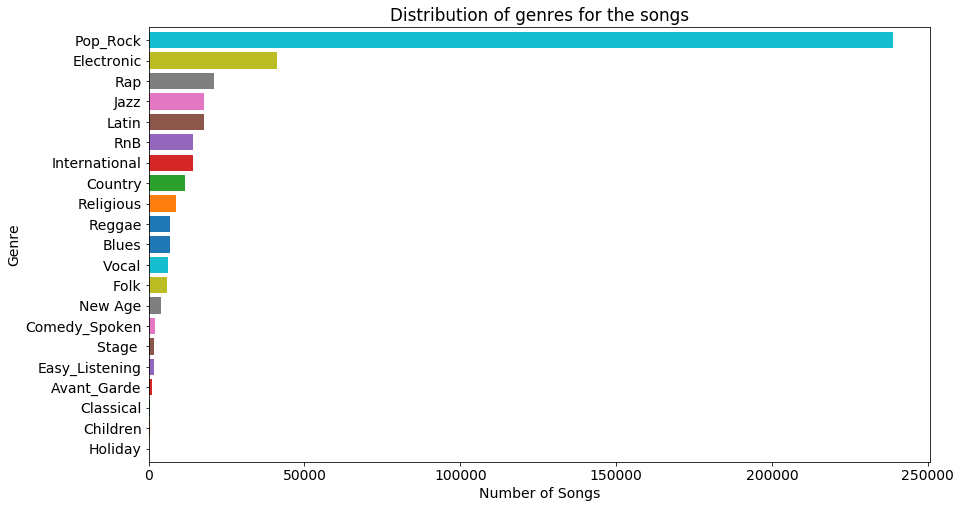

In [33]:
# bar chart of genres distribution
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 14})
genreDis['count'].plot(kind='barh',width =0.8)
plt.title('Distribution of genres for the songs')
plt.xlabel('Number of Songs')
plt.ylabel('Genre')

We perform the inner join between audio feature dataset and genre on trackID, to ensure that every song has label. 

In [34]:
dataset = (
    featuresData
        .join(
            MAGD,
            on = "trackID",
            how = "inner"
        )
)

show_as_html(dataset)

,trackID,F000,F001,F002,F003,F004,F005,F006,F007,F008,F009,F010,F011,F012,F013,F014,F015,genre
0,TRAAGTO128F1497E3C,5.699,0.03838,0.001236,274.8,0.001789,0.06716,0.08579,13.030,7.330,0.04096,0.000327,1754.0,0.001620,0.06190,0.6142,18.960,Pop_Rock
1,TRAAMFF12903CE8107,3.267,0.02975,0.005098,234.2,0.002431,0.07684,0.07589,11.040,4.381,0.02449,0.003194,1681.0,0.005744,0.20980,0.5657,16.200,Pop_Rock
2,TRAAUIH128F4254C9D,13.680,0.09743,0.004568,253.5,0.002828,0.09537,0.04466,29.220,11.620,0.07976,0.003496,1670.0,0.005586,0.20790,0.5182,33.540,Reggae
3,TRAAZNZ128F429EF86,2.151,0.01510,0.002339,313.1,0.001605,0.05131,0.10450,5.716,3.000,0.01887,0.000672,1753.0,0.002109,0.07594,0.6155,7.968,Pop_Rock
4,TRAAZOZ12903C9CABF,9.105,0.07933,0.001464,160.0,0.001404,0.05231,0.04957,22.330,14.120,0.10410,0.001351,1606.0,0.003109,0.12470,0.5421,42.130,Pop_Rock
5,TRABCWK128F42BBC0B,14.390,0.13420,0.003954,164.6,0.002357,0.08090,0.05017,33.420,15.650,0.12060,0.003471,1601.0,0.004545,0.18010,0.5392,49.260,Pop_Rock
6,TRABGUX12903CD11FF,5.346,0.05279,0.000837,195.9,0.001113,0.03719,0.06847,16.690,3.637,0.02123,0.000449,1562.0,0.001671,0.06217,0.6083,13.950,Rap
7,TRABHCK128F423E15A,4.200,0.03555,0.001214,231.6,0.001317,0.04669,0.05113,11.040,8.027,0.05080,0.001104,1664.0,0.003163,0.12360,0.5095,23.290,International
8,TRABIRM128F92CA303,6.157,0.04623,0.004473,181.4,0.001872,0.05868,0.05181,13.710,14.520,0.11220,0.003155,1573.0,0.004639,0.18630,0.6296,41.920,Pop_Rock
9,TRABMLM128F429BFA2,4.991,0.03965,0.000192,232.4,0.001848,0.06943,0.09764,12.680,9.264,0.05438,0.000089,1757.0,0.001916,0.07273,0.5610,20.320,Vocal


In [35]:
dataset.count()

420620

In [36]:
# check if every song has a label

dataset.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in dataset.columns]
   ).show()

+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+
|trackID|F000|F001|F002|F003|F004|F005|F006|F007|F008|F009|F010|F011|F012|F013|F014|F015|genre|
+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+
|      0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|    0|
+-------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+



The new dataset has 420,620 observations.

## Binary Classification

**To perform the binary classification on the dataset above, we decide to use RIDGE Regression, Random Forest and Gradient Boosted Tree algorithms from spark.ml library.**

The genre column was used as condition to create a new column call bi_genre, which has value of 1 when the genre column value is **Electronic**, 0 **otherwise**. The class balance of the binary label

In [37]:
# convert the genre column into a binary

bi_dataset = dataset.withColumn(
    'bi_genre',
    F.when((F.col('genre')=='Electronic'),1)
    .otherwise(0)
)

In [38]:
show_as_html(bi_dataset,5)

,trackID,F000,F001,F002,F003,F004,F005,F006,F007,F008,F009,F010,F011,F012,F013,F014,F015,genre,bi_genre
0,TRAAGTO128F1497E3C,5.699,0.03838,0.001236,274.8,0.001789,0.06716,0.08579,13.030,7.330,0.04096,0.000327,1754.0,0.001620,0.06190,0.6142,18.960,Pop_Rock,0
1,TRAAMFF12903CE8107,3.267,0.02975,0.005098,234.2,0.002431,0.07684,0.07589,11.040,4.381,0.02449,0.003194,1681.0,0.005744,0.20980,0.5657,16.200,Pop_Rock,0
2,TRAAUIH128F4254C9D,13.680,0.09743,0.004568,253.5,0.002828,0.09537,0.04466,29.220,11.620,0.07976,0.003496,1670.0,0.005586,0.20790,0.5182,33.540,Reggae,0
3,TRAAZNZ128F429EF86,2.151,0.01510,0.002339,313.1,0.001605,0.05131,0.10450,5.716,3.000,0.01887,0.000672,1753.0,0.002109,0.07594,0.6155,7.968,Pop_Rock,0
4,TRAAZOZ12903C9CABF,9.105,0.07933,0.001464,160.0,0.001404,0.05231,0.04957,22.330,14.120,0.10410,0.001351,1606.0,0.003109,0.12470,0.5421,42.130,Pop_Rock,0


In [39]:
# Compute class frequency
show_as_html(
    bi_dataset.groupBy('bi_genre')
    .agg(
        (F.count('bi_genre')).alias('count'),
        ((F.count('bi_genre') / bi_dataset.count())*100).alias('percentage')
    )
)

,bi_genre,count,percentage
0,0,379954,90.331891
1,1,40666,9.668109


As first, some variables in the dataset are significant correlated, so we have to make decision to remove those variables

Correlated features remove

In [40]:
# Explore correlations before we select what we need

assembler = VectorAssembler(
    inputCols=[col for col in bi_dataset.columns if col.startswith("F")],
    outputCol="features"
)

fRvmData = assembler.transform(bi_dataset)

correlations = Correlation.corr(fRvmData, 'features', 'pearson').collect()[0][0].toArray()

# Choose a threshold and visualize which correlations are above the threshold 

threshold = 0.95

display(pd.DataFrame(correlations.round(2)))
display(pd.DataFrame(correlations > threshold).astype(int))


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.00,0.95,0.22,0.04,0.30,0.33,0.14,0.97,0.61,0.57,0.09,-0.12,-0.01,-0.01,0.15,0.60
1,0.95,1.00,0.27,-0.03,0.32,0.34,0.06,0.97,0.59,0.57,0.15,-0.15,0.06,0.07,0.17,0.64
2,0.22,0.27,1.00,-0.02,0.89,0.86,-0.16,0.26,0.05,0.09,0.88,-0.24,0.78,0.76,0.23,0.16
3,0.04,-0.03,-0.02,1.00,0.04,0.06,0.30,0.01,-0.09,-0.13,-0.08,0.30,-0.09,-0.10,-0.06,-0.17
4,0.30,0.32,0.89,0.04,1.00,0.98,-0.06,0.34,-0.01,0.01,0.76,-0.19,0.73,0.70,0.16,0.07
5,0.33,0.34,0.86,0.06,0.98,1.00,-0.01,0.37,0.03,0.04,0.71,-0.17,0.69,0.67,0.16,0.10
6,0.14,0.06,-0.16,0.30,-0.06,-0.01,1.00,0.12,-0.03,-0.09,-0.31,0.11,-0.32,-0.32,0.02,-0.13
7,0.97,0.97,0.26,0.01,0.34,0.37,0.12,1.00,0.53,0.49,0.11,-0.12,0.03,0.02,0.17,0.56
8,0.61,0.59,0.05,-0.09,-0.01,0.03,-0.03,0.53,1.00,0.98,0.10,-0.09,0.02,0.07,0.15,0.95
9,0.57,0.57,0.09,-0.13,0.01,0.04,-0.09,0.49,0.98,1.00,0.17,-0.13,0.09,0.14,0.17,0.96


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1


In [41]:
# Remove variable with the most correlations above the threshold iteratively until there are no correlations above the threshold

indexes = np.array(list(range(0, n)))  # we need to keep track of which features to keep based on their index from 0 to n - 1

matrix = correlations.copy()
for j in range(0, correlations.shape[0]):
    
    # determine the index of the feature with the most correlations above the threshold

    mask = matrix > threshold

    sums = mask.sum(axis=0)
    index = np.argmax(sums)  

    if sums[index] - 1 > 0:
        
        # remove the feature if there are any correlations above the threshold (other than the correlation with itself)
        
        k = matrix.shape[0]
        keep = [i for i in range(0, k) if i != index]
        matrix = matrix[keep, :][:, keep]
        indexes = indexes[keep]
        
    else:

        # otherwise stop iterating
        
        break

In [42]:
# Check the correlations of the remaining features to ensure they are all below the threshold 

correlations_remaining = correlations[indexes, :][:, indexes]  # index the submatrix of correlations of the remaining features

display(pd.DataFrame(correlations_remaining.round(2)))
display(pd.DataFrame(correlations_remaining > threshold).astype(int))

,0,1,2,3,4,5,6,7,8,9
0,1.00,-0.02,0.86,-0.16,0.26,0.88,-0.24,0.76,0.23,0.16
1,-0.02,1.00,0.06,0.30,0.01,-0.08,0.30,-0.10,-0.06,-0.17
2,0.86,0.06,1.00,-0.01,0.37,0.71,-0.17,0.67,0.16,0.10
3,-0.16,0.30,-0.01,1.00,0.12,-0.31,0.11,-0.32,0.02,-0.13
4,0.26,0.01,0.37,0.12,1.00,0.11,-0.12,0.02,0.17,0.56
5,0.88,-0.08,0.71,-0.31,0.11,1.00,-0.29,0.92,0.04,0.23
6,-0.24,0.30,-0.17,0.11,-0.12,-0.29,1.00,-0.22,0.12,-0.14
7,0.76,-0.10,0.67,-0.32,0.02,0.92,-0.22,1.00,-0.08,0.20
8,0.23,-0.06,0.16,0.02,0.17,0.04,0.12,-0.08,1.00,0.19
9,0.16,-0.17,0.10,-0.13,0.56,0.23,-0.14,0.20,0.19,1.00


,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,1


In [43]:
# Assemble reamining features into vector for modeling

assembler = VectorAssembler(
    inputCols= np.array(bi_dataset.columns[1:-2])[indexes],
    outputCol="features"
)

fRvmData = assembler.transform(bi_dataset)

In [44]:
# Calculate new correlations and collect as array

correlations_new = Correlation.corr(fRvmData, 'features', 'pearson').collect()[0][0].toArray()
# Choose a threshold and visualize which correlations are above the threshold 

threshold = 0.95

display(pd.DataFrame(correlations_new.round(2)))
display(pd.DataFrame(correlations_new > threshold).astype(int))

,0,1,2,3,4,5,6,7,8,9
0,1.00,-0.02,0.86,-0.16,0.26,0.88,-0.24,0.76,0.23,0.16
1,-0.02,1.00,0.06,0.30,0.01,-0.08,0.30,-0.10,-0.06,-0.17
2,0.86,0.06,1.00,-0.01,0.37,0.71,-0.17,0.67,0.16,0.10
3,-0.16,0.30,-0.01,1.00,0.12,-0.31,0.11,-0.32,0.02,-0.13
4,0.26,0.01,0.37,0.12,1.00,0.11,-0.12,0.02,0.17,0.56
5,0.88,-0.08,0.71,-0.31,0.11,1.00,-0.29,0.92,0.04,0.23
6,-0.24,0.30,-0.17,0.11,-0.12,-0.29,1.00,-0.22,0.12,-0.14
7,0.76,-0.10,0.67,-0.32,0.02,0.92,-0.22,1.00,-0.08,0.20
8,0.23,-0.06,0.16,0.02,0.17,0.04,0.12,-0.08,1.00,0.19
9,0.16,-0.17,0.10,-0.13,0.56,0.23,-0.14,0.20,0.19,1.00


,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,1


After correlated feature reduction, we can do train/test split

In [45]:
# Features removed dataset
# Select what we need

rvmData = fRvmData.select(
    F.col('trackID'),
    F.col('bi_genre').alias('label'),
    F.col('features'),
)
rvmData.cache()
show_as_html(rvmData,5)

,trackID,label,features
0,TRAAGTO128F1497E3C,0,"[0.001236, 274.8, 0.06716, 0.08579, 13.03, 0.0..."
1,TRAAMFF12903CE8107,0,"[0.005098, 234.2, 0.07684, 0.07589, 11.04, 0.0..."
2,TRAAUIH128F4254C9D,0,"[0.004568, 253.5, 0.09537, 0.04466, 29.22, 0.0..."
3,TRAAZNZ128F429EF86,0,"[0.002339, 313.1, 0.05131, 0.1045, 5.716, 0.00..."
4,TRAAZOZ12903C9CABF,0,"[0.001464, 160.0, 0.05231, 0.04957, 22.33, 0.0..."


In [46]:
# Train - Test Split
# Features removed dataset
# Exact stratification using Window (multi-class, counts computed on the fly) 
tempRvm = (
    rvmData
    .withColumn("id", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

countsRvm = (
    rvmData
    .groupBy("label")
    .count()
    .toPandas()
    .set_index("label")["count"]
    .to_dict()
)
labelsRvm = sorted(countsRvm.keys())

trainingRvm = tempRvm
for label in labelsRvm:
    trainingRvm = trainingRvm.where((F.col("label") != label) | (F.col("row") < countsRvm[label] * 0.8))

trainingRvm.cache()

testRvm = tempRvm.join(trainingRvm, on="id", how="left_anti")
testRvm.cache()

trainingRvm = trainingRvm.drop("id", "random", "row")
testRvm = testRvm.drop("id", "random", "row")

print_class_balance(rvmData, "rvmData")
print_class_balance(trainingRvm, "trainingRvm")
print_class_balance(testRvm, "testRvm")

dataset: rvmData
total:   420620
counts:
   label   count     ratio
0      0  379954  0.903319
1      1   40666  0.096681

dataset: trainingRvm
total:   336495
counts:
   label   count     ratio
0      0  303963  0.903321
1      1   32532  0.096679

dataset: testRvm
total:   84125
counts:
   label  count     ratio
0      0  75991  0.903311
1      1   8134  0.096689



Removing features may cause missing some importance information, which lead to increase in bias, therefore we prefer to use the RIDGE Regression, Random Forest and Gradient Boosted Tree, which are all robust to correlated variables.

Moreover, RIDGE regression is very high in explainability and interpretability, fast train, which will be an idea to choose as base model. It also penalties the low importance or high correlated variables, butnot totally remove them with zero coefficient like LASSO, so all the features of the dataset are retained.

The Random Forests and Gradient Boosted Tree perform very well in classification, and don’t have much issue with dimensionality and scaling. However, those two are quite hard to explain and interpret.

All three models have quite many hyperparameters which enable us to boost the model performance through tuning process.

We now use the dataset without high correlated features reduction as the dataset to train our models. The train test split was applied Window function to make sure the exact stratification split based on binary label. The training test set split on proportion of 80:20.

#### Non - feature reduction dataset and train/test split

In [47]:
# Non features removed dataset
# Select what we need
assembler = VectorAssembler(
    inputCols=[col for col in bi_dataset.columns if col.startswith("F")],
    outputCol='features'
)

rawData = assembler.transform(bi_dataset)
rawData = rawData.select(
    F.col('trackID'),
    F.col('bi_genre').alias('label'),
    F.col('features'),
)
rawData.cache()
show_as_html(rawData,5)

,trackID,label,features
0,TRAAGTO128F1497E3C,0,"[5.699, 0.03838, 0.001236, 274.8, 0.001789, 0...."
1,TRAAMFF12903CE8107,0,"[3.267, 0.02975, 0.005098, 234.2, 0.002431, 0...."
2,TRAAUIH128F4254C9D,0,"[13.68, 0.09743, 0.004568, 253.5, 0.002828, 0...."
3,TRAAZNZ128F429EF86,0,"[2.151, 0.0151, 0.002339, 313.1, 0.001605, 0.0..."
4,TRAAZOZ12903C9CABF,0,"[9.105, 0.07933, 0.001464, 160.0, 0.001404, 0...."


In [48]:
# Train - Test Split
# Non features removed dataset
# Exact stratification using Window (multi-class, counts computed on the fly) 
temp = (
    rawData
    .withColumn("id", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

counts = (
    rawData
    .groupBy("label")
    .count()
    .toPandas()
    .set_index("label")["count"]
    .to_dict()
)
labels = sorted(counts.keys())

training = temp
for label in labels:
    training = training.where((F.col("label") != label) | (F.col("row") < counts[label] * 0.8))

training.cache()

test = temp.join(training, on="id", how="left_anti")
test.cache()

training = training.drop("id", "random", "row")
test = test.drop("id", "random", "row")

print_class_balance(rawData, "data")
print_class_balance(training, "training")
print_class_balance(test, "test")

dataset: data
total:   420620
counts:
   label   count     ratio
0      0  379954  0.903319
1      1   40666  0.096681

dataset: training
total:   336495
counts:
   label   count     ratio
0      0  303963  0.903321
1      1   32532  0.096679

dataset: test
total:   84125
counts:
   label  count     ratio
0      0  75991  0.903311
1      1   8134  0.096689



As we have sufficient observations for training the model, we would prefer the down sampling technique which reduces the number of observations of majority class 0 and not introduce any bias in to class 1 with sampling technique. However, we will work on all 3 sampling techniques for comparision purpose

#### No sampling

In [49]:
# No sampling

# Logistic Regression
lr = LogisticRegression(featuresCol='features', labelCol='label')
lrModel = lr.fit(training)
lrPred = lrModel.transform(test)
lrPred.cache()

print_metrics(lrPred)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        2164
nN:        81961

TP         1193
FP         971
FN         6941
TN         75020

precision: 0.55129390
recall:    0.14666831
accuracy:  0.90594948

auroc:     0.81847825



In [50]:
# No sampling

# Random forest
rfc = RandomForestClassifier(featuresCol='features', labelCol='label')
rfcModel = rfc.fit(training)

rfcPred = rfcModel.transform(test)
rfcPred.cache()

print_metrics(rfcPred)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        515
nN:        83610

TP         353
FP         162
FN         7781
TN         75829

precision: 0.68543689
recall:    0.04339808
accuracy:  0.90558098

auroc:     0.75532403



In [51]:
# No sampling

# Gradient-boosted tree
gbtc = GBTClassifier(featuresCol='features', labelCol='label')
gbtcModel = gbtc.fit(training)

gbtcPred = gbtcModel.transform(test)
gbtcPred.cache()

print_metrics(gbtcPred)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        1915
nN:        82210

TP         1194
FP         721
FN         6940
TN         75270

precision: 0.62349869
recall:    0.14679125
accuracy:  0.90893314

auroc:     0.82809339



#### Downsampling 

In [52]:
# Downsampling

training_downsampled = (
    training
    .withColumn("random", F.rand())
    .where((F.col("label") != 0) | ((F.col("label") == 0) & (F.col("random") < 2 * (40666 / 379954))))
)
training_downsampled.cache()

print_class_balance(training_downsampled, "training (downsampled)")

dataset: training (downsampled)
total:   97123
counts:
   label  count     ratio
0      0  64591  0.665043
1      1  32532  0.334957



In [53]:
# Downsampling

# RIDGE Regression
lr = LogisticRegression(featuresCol='features', labelCol='label',regParam=2.0, elasticNetParam=0.0)
lrModel = lr.fit(training_downsampled)
lrPred = lrModel.transform(test)
lrPred.cache()

print_metrics(lrPred)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        92
nN:        84033

TP         50
FP         42
FN         8084
TN         75949

precision: 0.54347826
recall:    0.00614704
accuracy:  0.90340565

auroc:     0.72409471



In [54]:
# Downsampling

# Random forest
rfc = RandomForestClassifier(featuresCol='features', labelCol='label')
rfcModel = rfc.fit(training_downsampled)

rfcPred = rfcModel.transform(test)
rfcPred.cache()

print_metrics(rfcPred)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        11528
nN:        72597

TP         3847
FP         7681
FN         4287
TN         68310

precision: 0.33370923
recall:    0.47295304
accuracy:  0.85773551

auroc:     0.79240538



In [55]:
# Downsampling

# Gradient-boosted tree
gbtc = GBTClassifier(featuresCol='features', labelCol='label')
gbtcModel = gbtc.fit(training_downsampled)

gbtcPred = gbtcModel.transform(test)
gbtcPred.cache()

print_metrics(gbtcPred)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        13393
nN:        70732

TP         4703
FP         8690
FN         3431
TN         67301

precision: 0.35115359
recall:    0.57819031
accuracy:  0.85591679

auroc:     0.82953025



#### Upsampling

In [56]:
# Upsampling via uniform random sampling (with replacement)

ratio = 10
n = 20
p = ratio / n  # ratio < n such that probability < 1

def random_upsample(label, n, p):
    # Can implement custom sampling logic per class based on class counts
    if label == 0:
        return [0]  # no sampling
    if label == 1:
        return list(range((np.sum(np.random.random(n) > p))))  # upsampling
    return []  # drop

random_upsample_udf = F.udf(lambda x: random_upsample(x, n, p), ArrayType(IntegerType()))

training_upsampled = (
    training
    .withColumn("sample", random_upsample_udf(F.col("label")))
    .select(
        F.col("trackID"),
        F.col("label"),
        F.col("features"),
        F.explode(F.col("sample")).alias("sample")
    )
    .drop("sample")
)
training_upsampled.cache()

print_class_balance(training_upsampled, "training (upsampled)")

dataset: training (upsampled)
total:   629367
counts:
   label   count     ratio
0      0  303963  0.482966
1      1  325404  0.517034



In [57]:
# Upsampling

# Logistic Regression
lr = LogisticRegression(featuresCol='features', labelCol='label')
lrModel = lr.fit(training_upsampled)
lrPred = lrModel.transform(test)
lrPred.cache()

print_metrics(lrPred)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        20648
nN:        63477

TP         5818
FP         14830
FN         2316
TN         61161

precision: 0.28177063
recall:    0.71526924
accuracy:  0.79618425

auroc:     0.82179613



In [58]:
# Upsampling

# Random forest
rfc = RandomForestClassifier(featuresCol='features', labelCol='label')
rfcModel = rfc.fit(training_upsampled)

rfcPred = rfcModel.transform(test)
rfcPred.cache()

print_metrics(rfcPred)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        23139
nN:        60986

TP         5615
FP         17524
FN         2519
TN         58467

precision: 0.24266390
recall:    0.69031227
accuracy:  0.76174740

auroc:     0.79729922



In [59]:
# Upsampling

# Gradient-boosted tree
gbtc = GBTClassifier(featuresCol='features', labelCol='label')
gbtcModel = gbtc.fit(training_upsampled)

gbtcPred = gbtcModel.transform(test)
gbtcPred.cache()

print_metrics(gbtcPred)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        25338
nN:        58787

TP         6146
FP         19192
FN         1988
TN         56799

precision: 0.24256058
recall:    0.75559380
accuracy:  0.74823180

auroc:     0.82872825



#### Hyperparameter Tunning

Cross validation 5 folds was use to tune our hyperparameter. With RIDGE model, we tune the aggregationDepth, maxIter, and regParam (ʎ) parameters. The elasticNetParam (α) was kept at 0 since we using RIDGE algorithm. The Random Forest was focused on tuning maxDepth, maxBins, and numTrees. While, the Gradient Boosted Tree was tuned on maxDepth, maxBins, and maxIter.

In [60]:
# Downsampling

training_downsampled = (
    training
    .withColumn("random", F.rand())
    .where((F.col("label") != 0) | ((F.col("label") == 0) & (F.col("random") < 2 * (40666 / 379954))))
)
training_downsampled.cache()

print_class_balance(training_downsampled, "training (downsampled)")

dataset: training (downsampled)
total:   97815
counts:
   label  count     ratio
0      0  65283  0.667413
1      1  32532  0.332587



In [61]:
# binary evaluator 
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='label', metricName='areaUnderROC')

In [62]:
# Downsampling

# RIDGE Regression

lrGrid = (ParamGridBuilder()
    .addGrid(lr.aggregationDepth,[2,5,10])
    .addGrid(lr.elasticNetParam,[0.0])
    .addGrid(lr.maxIter,[10, 20, 50])
    .addGrid(lr.regParam,[0.1, 0.2, 0.5,1.0])
    .build()
            )

lrCv = CrossValidator(estimator=lr, estimatorParamMaps=lrGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
lrCvModel = lrCv.fit(training_downsampled)

lrCvPred = lrCvModel.transform(test)
lrCvPred.cache()

print_metrics(lrCvPred)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        7431
nN:        76694

TP         2708
FP         4723
FN         5426
TN         71268

precision: 0.36441932
recall:    0.33292353
accuracy:  0.87935810

auroc:     0.76610978



In [63]:
# Downsampling

# Random forest

rfcGrid = (ParamGridBuilder()
    .addGrid(rfc.maxDepth, [2, 5, 10])
    .addGrid(rfc.maxBins, [5, 10, 20])
    .addGrid(rfc.numTrees, [5, 20, 50])
    .build()
          )

rfcCv = CrossValidator(estimator=rfc, estimatorParamMaps=rfcGrid, evaluator=evaluator, numFolds=5)

rfcCvModel = rfcCv.fit(training_downsampled)

rfcCvPred = rfcCvModel.transform(test)
rfcCvPred.cache()

print_metrics(rfcCvPred)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        12349
nN:        71776

TP         4517
FP         7832
FN         3617
TN         68159

precision: 0.36577861
recall:    0.55532333
accuracy:  0.86390490

auroc:     0.83314069



In [64]:
# Downsampling

# Gradient-boosted tree

gbtcGrid = (ParamGridBuilder()
    .addGrid(gbtc.maxDepth, [2, 5, 10])
    .addGrid(gbtc.maxBins, [10, 20, 40])
    .addGrid(gbtc.maxIter, [10, 20, 50])
    .build()
          )

gbtcCv = CrossValidator(estimator=gbtc, estimatorParamMaps=gbtcGrid, evaluator=evaluator, numFolds=5)

gbtcCvModel = gbtcCv.fit(training_downsampled)

gbtcCvPred = gbtcCvModel.transform(test)
gbtcCvPred.cache()

print_metrics(gbtcCvPred)

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        13912
nN:        70213

TP         4960
FP         8952
FN         3174
TN         67039

precision: 0.35652674
recall:    0.60978608
accuracy:  0.85585736

auroc:     0.84519455



## Multiclass classification 

**Random Forest** model was pick to work on multiclass classification problem across all genres of our dataset. This model work well on both binary and multiclass classification. Besides, this model train much faster than the Gradient Boosted Tree. In the situation, when the cluster resource is limited and shared by many students, Random Forest is our favourable method.


To convert the genre column to integer, we use StringIndexer function, to ensure the consistently encoding. While training our model, we tried two different scenarios. In the first scenario, the model used the dataset without any sampling or adjustment method. In the second scenario, we applied class weighted method, which add a weight column to dataset, and use it during training the model.

In [65]:
# Convert the genre column into an integer index
show_as_html(dataset,5)

indexer = StringIndexer(inputCol='genre', outputCol='genreIndex')
mcDataset = indexer.fit(dataset).transform(dataset)


show_as_html(mcDataset,10)

,trackID,F000,F001,F002,F003,F004,F005,F006,F007,F008,F009,F010,F011,F012,F013,F014,F015,genre
0,TRAAGTO128F1497E3C,5.699,0.03838,0.001236,274.8,0.001789,0.06716,0.08579,13.030,7.330,0.04096,0.000327,1754.0,0.001620,0.06190,0.6142,18.960,Pop_Rock
1,TRAAMFF12903CE8107,3.267,0.02975,0.005098,234.2,0.002431,0.07684,0.07589,11.040,4.381,0.02449,0.003194,1681.0,0.005744,0.20980,0.5657,16.200,Pop_Rock
2,TRAAUIH128F4254C9D,13.680,0.09743,0.004568,253.5,0.002828,0.09537,0.04466,29.220,11.620,0.07976,0.003496,1670.0,0.005586,0.20790,0.5182,33.540,Reggae
3,TRAAZNZ128F429EF86,2.151,0.01510,0.002339,313.1,0.001605,0.05131,0.10450,5.716,3.000,0.01887,0.000672,1753.0,0.002109,0.07594,0.6155,7.968,Pop_Rock
4,TRAAZOZ12903C9CABF,9.105,0.07933,0.001464,160.0,0.001404,0.05231,0.04957,22.330,14.120,0.10410,0.001351,1606.0,0.003109,0.12470,0.5421,42.130,Pop_Rock


,trackID,F000,F001,F002,F003,F004,F005,F006,F007,F008,F009,F010,F011,F012,F013,F014,F015,genre,genreIndex
0,TRAAGTO128F1497E3C,5.699,0.03838,0.001236,274.8,0.001789,0.06716,0.08579,13.030,7.330,0.04096,0.000327,1754.0,0.001620,0.06190,0.6142,18.960,Pop_Rock,0.0
1,TRAAMFF12903CE8107,3.267,0.02975,0.005098,234.2,0.002431,0.07684,0.07589,11.040,4.381,0.02449,0.003194,1681.0,0.005744,0.20980,0.5657,16.200,Pop_Rock,0.0
2,TRAAUIH128F4254C9D,13.680,0.09743,0.004568,253.5,0.002828,0.09537,0.04466,29.220,11.620,0.07976,0.003496,1670.0,0.005586,0.20790,0.5182,33.540,Reggae,9.0
3,TRAAZNZ128F429EF86,2.151,0.01510,0.002339,313.1,0.001605,0.05131,0.10450,5.716,3.000,0.01887,0.000672,1753.0,0.002109,0.07594,0.6155,7.968,Pop_Rock,0.0
4,TRAAZOZ12903C9CABF,9.105,0.07933,0.001464,160.0,0.001404,0.05231,0.04957,22.330,14.120,0.10410,0.001351,1606.0,0.003109,0.12470,0.5421,42.130,Pop_Rock,0.0
5,TRABCWK128F42BBC0B,14.390,0.13420,0.003954,164.6,0.002357,0.08090,0.05017,33.420,15.650,0.12060,0.003471,1601.0,0.004545,0.18010,0.5392,49.260,Pop_Rock,0.0
6,TRABGUX12903CD11FF,5.346,0.05279,0.000837,195.9,0.001113,0.03719,0.06847,16.690,3.637,0.02123,0.000449,1562.0,0.001671,0.06217,0.6083,13.950,Rap,2.0
7,TRABHCK128F423E15A,4.200,0.03555,0.001214,231.6,0.001317,0.04669,0.05113,11.040,8.027,0.05080,0.001104,1664.0,0.003163,0.12360,0.5095,23.290,International,6.0
8,TRABIRM128F92CA303,6.157,0.04623,0.004473,181.4,0.001872,0.05868,0.05181,13.710,14.520,0.11220,0.003155,1573.0,0.004639,0.18630,0.6296,41.920,Pop_Rock,0.0
9,TRABMLM128F429BFA2,4.991,0.03965,0.000192,232.4,0.001848,0.06943,0.09764,12.680,9.264,0.05438,0.000089,1757.0,0.001916,0.07273,0.5610,20.320,Vocal,11.0


In [66]:
# Non features removed dataset
# Select what we need

assembler = VectorAssembler(
    inputCols=[col for col in mcDataset.columns if col.startswith("F")],
    outputCol='features'
)

mcData = assembler.transform(mcDataset)
mcData = mcData.select(
    F.col('trackID'),
    F.col('genreIndex').alias('label'),
    F.col('features'),
)
mcData.cache()
show_as_html(mcData,5)

,trackID,label,features
0,TRAAGTO128F1497E3C,0.0,"[5.699, 0.03838, 0.001236, 274.8, 0.001789, 0...."
1,TRAAMFF12903CE8107,0.0,"[3.267, 0.02975, 0.005098, 234.2, 0.002431, 0...."
2,TRAAUIH128F4254C9D,9.0,"[13.68, 0.09743, 0.004568, 253.5, 0.002828, 0...."
3,TRAAZNZ128F429EF86,0.0,"[2.151, 0.0151, 0.002339, 313.1, 0.001605, 0.0..."
4,TRAAZOZ12903C9CABF,0.0,"[9.105, 0.07933, 0.001464, 160.0, 0.001404, 0...."


In [67]:
# Train - Test Split
# Non features removed dataset
# Exact stratification using Window (multi-class, counts computed on the fly) 
temp = (
    mcData
    .withColumn("id", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

counts = (
    mcData
    .groupBy("label")
    .count()
    .toPandas()
    .set_index("label")["count"]
    .to_dict()
)
labels = sorted(counts.keys())

mcTraining = temp
for label in labels:
    mcTraining = mcTraining.where((F.col("label") != label) | (F.col("row") < counts[label] * 0.8))

mcTraining.cache()

mcTest = temp.join(mcTraining, on="id", how="left_anti")
mcTest.cache()

mcTraining = mcTraining.drop("id", "random", "row")
mcTest = mcTest.drop("id", "random", "row")

print_class_balance(mcData, "Multi Class Data")
print_class_balance(mcTraining, "Multi Class Training")
print_class_balance(mcTest, "Multi Class Test")

dataset: Multi Class Data
total:   420620
counts:
    label   count     ratio
0    19.0     463  0.001101
1     7.0   11691  0.027795
2     4.0   17504  0.041615
3    20.0     200  0.000475
4     9.0    6931  0.016478
5    18.0     555  0.001319
6     3.0   17775  0.042259
7    11.0    6182  0.014697
8    12.0    5789  0.013763
9     1.0   40666  0.096681
10   14.0    2067  0.004914
11    0.0  237649  0.564997
12    2.0   20899  0.049686
13    6.0   14194  0.033745
14   13.0    4000  0.009510
15   16.0    1535  0.003649
16   10.0    6801  0.016169
17    5.0   14314  0.034031
18   17.0    1012  0.002406
19    8.0    8780  0.020874
20   15.0    1613  0.003835

dataset: Multi Class Training
total:   336483
counts:
    label   count     ratio
0    19.0     370  0.001100
1     7.0    9352  0.027793
2     4.0   14003  0.041616
3    20.0     159  0.000473
4     9.0    5544  0.016476
5    18.0     443  0.001317
6     3.0   14219  0.042258
7    11.0    4945  0.014696
8    12.0    4631  0.013763

Our dataset is imbalanced heavily, we can see the proportion of each class showed above

### Multiclass Random Forest without sampling

In [68]:
# Multi class Random forest without sampling

rf = RandomForestClassifier(featuresCol='features', labelCol='label')

# AUROC does make sense in multiclass classification. AUROC metric isn't available under MulticlassClassificationEvaluator
mcEvaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1') 

rfGrid = (ParamGridBuilder()
    .addGrid(rf.maxDepth, [2, 5, 10])
    .addGrid(rf.maxBins, [5, 10, 20])
    .addGrid(rf.numTrees, [5, 20, 50])
    .build()
          )

rfCv = CrossValidator(estimator=rf, estimatorParamMaps=rfGrid, evaluator=mcEvaluator, numFolds=5)

rfCvModel = rfCv.fit(mcTraining)
rfCvPred = rfCvModel.transform(mcTest)
rfCvPred.cache()

DataFrame[trackID: string, label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [69]:
# Performance metrics

y_true = rfCvPred.select(['label']).toPandas()
y_pred = rfCvPred.select(['prediction']).toPandas()
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

        0.0       0.60      0.97      0.74     47530
        1.0       0.51      0.23      0.32      8134
        2.0       0.44      0.29      0.35      4180
        3.0       0.32      0.05      0.08      3556
        4.0       0.76      0.01      0.02      3501
        5.0       0.65      0.00      0.01      2863
        6.0       0.00      0.00      0.00      2839
        7.0       0.00      0.00      0.00      2339
        8.0       0.00      0.00      0.00      1757
        9.0       0.00      0.00      0.00      1387
       10.0       0.00      0.00      0.00      1361
       11.0       0.00      0.00      0.00      1237
       12.0       0.00      0.00      0.00      1158
       13.0       0.48      0.03      0.06       801
       14.0       0.00      0.00      0.00       414
       15.0       0.00      0.00      0.00       323
       16.0       0.00      0.00      0.00       308
       17.0       0.00      0.00      0.00   

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The performance of Random Forest drops significantly in the case of multiclass classification, especially when our dataset is imbalanced. In the first scenario, without class weight, our model failed to predict many classes (class labelled 6 to 12, and 14 to 20), 14 out of 21 have 0 score for both precision and recall. Those classes only have the proportions of observations around 1%-3% in compare to 56% of class 0.

Performance of the RF seems to be poor, due to class balance. We try to introduce class weight into our model, and re train it again

### RF with weighted class

In [70]:
# create weight column 
# code credit for https://danvatterott.com/blog/2019/11/18/balancing-model-weights-in-pyspark/

label_collect = mcTraining.select('label').groupBy('label').count().collect()
unique_label = [x['label'] for x in label_collect]
total_label = sc.parallelize([x['count'] for x in label_collect]).sum()
unique_label_count = len(label_collect)
bin_count = [x['count'] for x in label_collect]

class_weights = {i: ii for i, ii in zip(unique_label, total_label / (unique_label_count * np.array(bin_count)))}

mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights.items())])

mcTrainingWeight = mcTraining.withColumn("weight", mapping_expr.getItem(F.col('label')))

show_as_html(mcTrainingWeight)

,trackID,label,features,weight
0,TRRTFNA128F424707C,19.0,"[4.617, 0.04434, 0.001872, 267.8, 0.001845, 0....",43.305405
1,TRAPQRP128F422B174,19.0,"[9.519, 0.0682, 0.001034, 283.2, 0.00125, 0.04...",43.305405
2,TRFVTBE128F14AB497,19.0,"[1.386, 0.01054, 0.0002327, 246.0, 0.0007301, ...",43.305405
3,TRBBEUI128F42A1E1F,19.0,"[6.81, 0.06438, 0.001633, 222.8, 0.001443, 0.0...",43.305405
4,TRHPZOW128F422B16C,19.0,"[5.624, 0.04895, 0.003643, 329.5, 0.002227, 0....",43.305405
5,TRVDWCK128F4269472,19.0,"[3.128, 0.02211, 0.0003231, 225.5, 0.001182, 0...",43.305405
6,TRRWKUC128F934550C,19.0,"[5.274, 0.049, 0.0008796, 219.4, 0.0009793, 0....",43.305405
7,TRNRQMV128F92FA824,19.0,"[10.37, 0.08918, 0.003168, 189.9, 0.002416, 0....",43.305405
8,TRLGDHS128F425D07A,19.0,"[5.631, 0.0407, 0.005801, 200.7, 0.003035, 0.0...",43.305405
9,TRGAUFN128F92DE593,19.0,"[9.408, 0.07959, 0.002826, 201.5, 0.001727, 0....",43.305405


In [71]:
# Multi class Random forest without sampling but class weight added

rfw = RandomForestClassifier(featuresCol='features', labelCol='label',weightCol = 'weight')

mcwEvaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label',weightCol = 'weight', metricName='f1') 

rfwGrid = (ParamGridBuilder()
    .addGrid(rfw.maxDepth, [2, 5, 10])
    .addGrid(rfw.maxBins, [5, 10, 20])
    .addGrid(rfw.numTrees, [5, 20, 50])
    .build()
          )

rfwCv = CrossValidator(estimator=rfw, estimatorParamMaps=rfwGrid, evaluator=mcwEvaluator, numFolds=5)

rfwCvModel = rfwCv.fit(mcTrainingWeight)
rfwCvPred = rfwCvModel.transform(mcTest)
rfwCvPred.cache()

DataFrame[trackID: string, label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [72]:
# Performance metrics

wy_true = rfwCvPred.select(['label']).toPandas()
wy_pred = rfwCvPred.select(['prediction']).toPandas()
print(classification_report(wy_true, wy_pred))

             precision    recall  f1-score   support

        0.0       0.89      0.38      0.54     47530
        1.0       0.37      0.28      0.32      8134
        2.0       0.28      0.54      0.37      4180
        3.0       0.18      0.07      0.10      3556
        4.0       0.18      0.17      0.17      3501
        5.0       0.17      0.17      0.17      2863
        6.0       0.11      0.02      0.03      2839
        7.0       0.10      0.17      0.13      2339
        8.0       0.06      0.09      0.07      1757
        9.0       0.11      0.48      0.18      1387
       10.0       0.05      0.18      0.08      1361
       11.0       0.10      0.37      0.15      1237
       12.0       0.05      0.11      0.07      1158
       13.0       0.09      0.38      0.15       801
       14.0       0.09      0.74      0.16       414
       15.0       0.06      0.29      0.10       323
       16.0       0.03      0.32      0.05       308
       17.0       0.05      0.24      0.08   

In the second scenario, the class weighted column did help to improve the model slightly. We were be able to make some correct predictions in across all classes (genres), event some minority classes with proportion of observations account for 0.1% or even 0.04%.